In [27]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import time
import random

In [28]:
print("Loading MNIST dataset...")

# Define the path to the dataset
data_path = '../../data/external'

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the training set
train_set = torchvision.datasets.MNIST(root=data_path, train=True, download=False, transform=transform)

# Load the test set
test_set = torchvision.datasets.MNIST(root=data_path, train=False, download=False, transform=transform)

print("MNIST dataset loaded successfully!")

Loading MNIST dataset...
MNIST dataset loaded successfully!


Displaying a random image from MNIST (index: 19686)


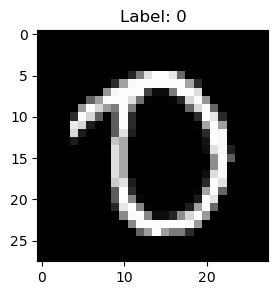

In [29]:
def show_image(img, label):
    plt.figure(figsize=(3,3))
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('on')
    plt.show()
    
# Get a random image from the training set
random_idx = torch.randint(0, len(train_set), (1,)).item()
img, label = train_set[random_idx]

print(f"Displaying a random image from MNIST (index: {random_idx})")
show_image(img, label)

In [30]:
# Print some information about the dataset
print(f"Number of training samples: {len(train_set)}")
print(f"Number of test samples: {len(test_set)}")
print(f"Image shape: {train_set[0][0].shape}")

Number of training samples: 60000
Number of test samples: 10000
Image shape: torch.Size([1, 28, 28])


In [31]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [32]:
# Instantiate the network
model = Net()

print("Convolutional Neural Network defined:")
print(model)

Convolutional Neural Network defined:
Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [33]:
# If CUDA is available, move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model moved to device: {device}")

Model moved to device: cuda


In [34]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("Loss function: Cross Entropy Loss")
print("Optimizer: Adam with learning rate 0.001")

Loss function: Cross Entropy Loss
Optimizer: Adam with learning rate 0.001


In [35]:
# Set hyperparameters
batch_size = 64
epochs = 5

# Create data loaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Lists to store metrics
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [36]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    
    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    return train_loss, train_accuracy

In [44]:
def test(model, device, test_loader):
    model.eval()
    all_preds = []
    all_targets =  []
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({test_accuracy:.2f}%)\n')
    return test_loss, test_accuracy, np.array(all_preds), np.array(all_targets)

/home/rayann/miniconda3/envs/ros_env/lib/python3.11/site-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.124876
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.027070
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.011789
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.021020
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.031292
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.034066
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.019695
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.005718
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.024519
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.004521

Test set: Average loss: 0.0288, Accuracy: 9904/10000 (99.04%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.002744
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.045265
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.034173
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.049057
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.096208
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.009209
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.020343
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.095239
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.07091

ValueError: x and y must have same first dimension, but have shapes (5,) and (10,)

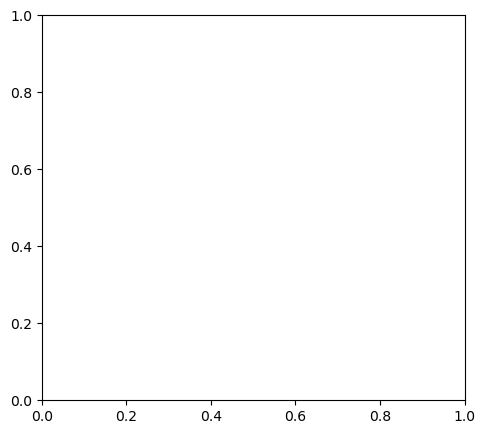

In [45]:
# Training loop
start_time = time.time()
for epoch in range(1, epochs + 1):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_accuracy, _, _ = test(model, device, test_loader)

end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Plotting the results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train')
plt.plot(range(1, epochs + 1), test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Test Accuracy')

plt.tight_layout()
plt.show()

In [46]:
def predict_and_display(model, device, dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    model.eval()

    with torch.no_grad():
        for i in range(num_images):
            idx = random.randint(0, len(dataset) - 1)
            img, true_label = dataset[idx]
            
            # Make prediction
            img = img.unsqueeze(0).to(device)
            output = model(img)
            pred_label = output.argmax(dim=1, keepdim=True).item()
            
            # Display image and prediction
            axes[i].imshow(img.cpu().squeeze(), cmap='gray')
            axes[i].set_title(f'Pred: {pred_label}\nTrue: {true_label}')
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

Making predictions for 5 random images from the test set:


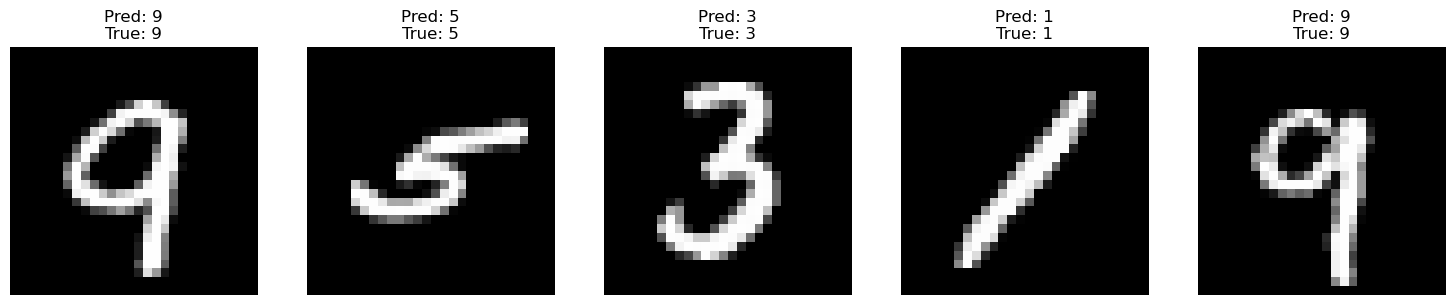

Overall accuracy on the test set: 99.23%


In [47]:
print("Making predictions for 5 random images from the test set:")
predict_and_display(model, device, test_set)

# Calculate overall accuracy on the test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

accuracy = 100 * correct / total
print(f'Overall accuracy on the test set: {accuracy:.2f}%')

/home/rayann/miniconda3/envs/ros_env/lib/python3.11/site-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)



Test set: Average loss: 0.0281, Accuracy: 9923/10000 (99.23%)



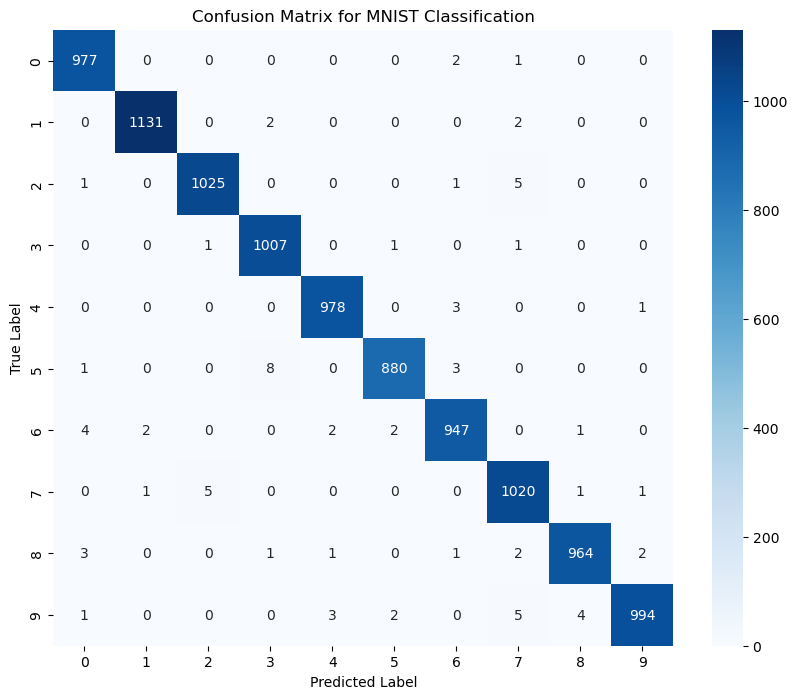

In [49]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    
    plt.title('Confusion Matrix for MNIST Classification')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.savefig(f"confusion_matrix.png", dpi=600, bbox_inches='tight', format='png')
    plt.show()

_, _, predictions, targets = test(model, device, test_loader)
plot_confusion_matrix(targets, predictions)

In [ ]:
torch.save(model.state_dict(), '../../model/mnist_cnn.pth')